<a href="https://colab.research.google.com/github/kosebaris1/CNN_siniflandirma/blob/main/Model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

### 👤 Öğrenci Bilgileri
* **Adınız:** Barış
* **Soyadınız:** Köse
* **Okul Numaranız:** 2212721022
* **GitHub Repo Bağlantısı:** https://github.com/kosebaris1/CNN_siniflandirma
---



# Model 2: Temel CNN Mimarisi (Sıfırdan Eğitim)

## Giriş ve Amaç
Bu aşamada, transfer learning kullanmadan, sıfırdan tasarlanan temel bir **Evrişimli Sinir Ağı (Convolutional Neural Network - CNN)** modeli oluşturulmuştur.
Bu modelin amacı, **referans (baseline)** bir başarı skoru elde etmektir.
## Veri Seti Hazırlığı
Adil bir karşılaştırma (Benchmarking) yapabilmek için veri seti, Model 1'deki ile **birebir aynı oranlarda (%70 Eğitim, %15 Doğrulama, %15 Test)** ve aynı rastgelelik tohumu (`seed=1337`) ile ayrıştırılmıştır. Böylece her iki model de (VGG16 ve Temel CNN) aynı görüntüleri eğitim ve test için kullanacaktır.

In [1]:
# KURULUM, DRIVE VE VERİ AYRIŞTIRMA
!pip install split-folders
import tensorflow as tf
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import os
from google.colab import drive

# 1. Drive Bağlantısı
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Veri Yolları
input_folder = '/content/drive/MyDrive/Colab Notebooks/datasets'
output_folder = '/content/split_dataset_model2' # Model 2 için geçici klasör(hızlı olduğundan bu yöntemi seçtim)

# 3. Veriyi Ayırma (%70 Train, %15 Val, %15 Test)
# Model 1 ile aynı train,test,val fotoları.
print("Veriler Train, Val ve Test olarak ayrıştırılıyor...")
splitfolders.ratio(input_folder, output=output_folder,
                   seed=1337, ratio=(.7, .15, .15), group_prefix=None, move=False)
print("Ayrıştırma Tamamlandı!")

Mounted at /content/drive
Veriler Train, Val ve Test olarak ayrıştırılıyor...


Copying files: 541 files [00:39, 13.78 files/s]

Ayrıştırma Tamamlandı!


## Veri Ön İşleme (Preprocessing)

Modelin eğitimi için görüntüler normalize edilmiş ve boyutlandırılmıştır.

* **Rescaling (Normalizasyon):** Görüntü piksel değerleri (0-255), sinir ağının daha hızlı ve kararlı öğrenmesi için 0-1 aralığına (`1./255`) ölçeklenmiştir.
* **Veri Artırımı (Augmentation) Yok:** Bu model "Temel Model" olduğu için, veri artırımı (döndürme, kaydırma vb.) **bilinçli olarak uygulanmamıştır**. Amacımız, ham veri ile modelin saf performansını görmektir. İyileştirmeler Model 3 aşamasında yapılacaktır.

In [2]:
# GENERATOR (ÜRETEÇLER)
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)

# Eğitim Seti
train_generator = datagen.flow_from_directory(
    f'{output_folder}/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Doğrulama Seti
validation_generator = datagen.flow_from_directory(
    f'{output_folder}/val',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test Seti (Shuffle=False)
test_generator = datagen.flow_from_directory(
    f'{output_folder}/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 378 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


## CNN Mimarisi Tasarımı

Modelimiz, görüntüden öznitelik çıkaran **Evrişim Blokları** ve karar veren **Sınıflandırma Katmanları** olmak üzere iki ana bölümden oluşmakta:

### 1. Öznitelik Çıkarımı (Feature Extraction)
* **Conv2D (Evrişim) Katmanları:** * İlk blokta **32 filtre**, ikinci blokta **64 filtre** kullanılmıştır.
    * Bu katmanlar görüntü üzerinde gezerek kenar, köşe, renk geçişleri gibi görsel özellikleri tespit eder.
    * **ReLU Aktivasyonu:** Negatif değerleri sıfırlayarak modelin doğrusal olmayan (non-linear) karmaşık ilişkileri öğrenmesini sağlar.
* **MaxPooling2D (Havuzlama):** * Görüntü boyutunu yarıya indirir (Downsampling).
    * Bu işlem hem işlem gücünden tasarruf sağlar hem de modelin küçük kaymalara karşı daha dayanıklı olmasını (Translation Invariance) sağlar.

### 2. Sınıflandırma (Classification)
* **Flatten (Düzleştirme):** 2 boyutlu özellik haritalarını, yoğun katmanlara verebilmek için tek boyutlu vektöre dönüştürür.
* **Dense (128 Nöron):** Modelin öğrenme kapasitesini oluşturan, tam bağlantılı (fully connected) "beyin" katmanıdır.
* **Dense (Çıktı - Softmax):** 2 sınıfımız (TL ve USD) olduğu için, her sınıfa ait olasılık değerini üreten son katmandır.

In [3]:
# MODEL 2 MİMARİSİ (TEMEL CNN)

model2 = Sequential([
    # 1. Blok
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    # 2. Blok
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Sınıflandırma
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax') # 2 Sınıf: TL ve USD
])

model2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model2.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

## Modelin Eğitilmesi

Model, `Adam` optimizasyon algoritması ve `Categorical Crossentropy` kayıp fonksiyonu ile derlenmiştir.
* **Epoch Sayısı (15):** Modelimiz VGG16'ya göre daha küçük ve sıfırdan öğrendiği için, öğrenme sürecinin tamamlanması adına 15 epoch şeçtim.
* **Batch Size (32):** Öğrenme kararlılığını arttırmak için Gradyan güncellemeleri her 32 görüntüde bir yapıldı.

In [4]:
# EĞİTİM
print("\n--- Model 2 Eğitiliyor ---")
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=15, # Temel model olduğundan 15 epoch olarak belirledim
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)


--- Model 2 Eğitiliyor ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.4585 - loss: 2.0829 - val_accuracy: 0.4844 - val_loss: 0.6691
Epoch 2/15
 1/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5938 - loss: 0.5985

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 833ms/step - accuracy: 0.5938 - loss: 0.5985 - val_accuracy: 0.4688 - val_loss: 0.6514
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - accuracy: 0.7258 - loss: 0.5196 - val_accuracy: 0.7812 - val_loss: 0.4482
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 819ms/step - accuracy: 0.8750 - loss: 0.4000 - val_accuracy: 0.8281 - val_loss: 0.3368
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - accuracy: 0.8237 - loss: 0.4447 - val_accuracy: 0.7969 - val_loss: 0.4131
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7812 - loss: 0.3843 - val_accuracy: 0.8750 - val_loss: 0.3228
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.8639 - loss: 0.3212 - val_accuracy: 0.9062 - val_loss: 0.2872
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 856ms/step - accuracy: 0.9375 - loss: 0.2180 - val_accuracy: 0.8750 - val_loss: 0.2550
Epoch 9/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.9322 - loss: 0.1840 - val_accuracy: 0.9219 - val_loss: 0

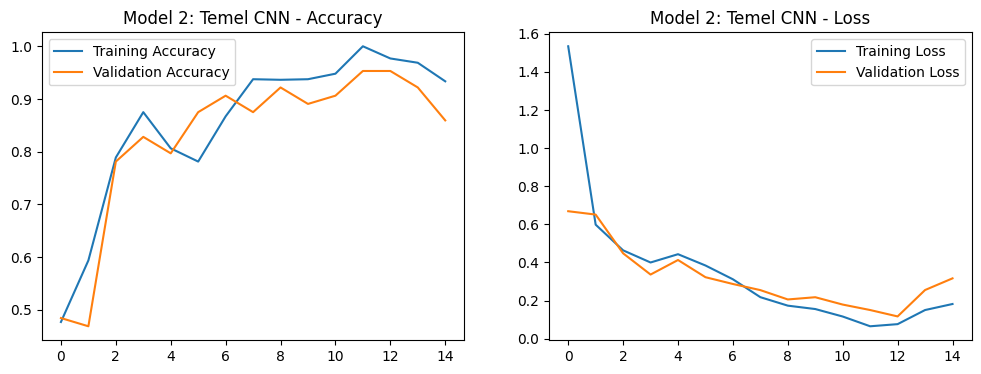

In [5]:
# SONUÇLAR VE GRAFİK
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.show()

plot_history(history2, "Model 2: Temel CNN")

## Final Test Sonucu

Modelin başarısı, eğitim sırasında hiç görmediği **Test Seti** üzerinde ölçülmüştür.Aşağıda görüldüğü üzere final Test Doğruluğu %89.16
çıkmıştır.

In [6]:
#  TEST SETİ DEĞERLENDİRMESİ

print("TEST AŞAMASI (Model 2)")
test_loss, test_acc = model2.evaluate(test_generator)
print(f"\n Model 2 FİNAL Test Doğruluğu: %{test_acc*100:.2f}")

TEST AŞAMASI (Model 2)
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.9341 - loss: 0.2027

 Model 2 FİNAL Test Doğruluğu: %89.16
